In [1]:
import torch
import torch.nn as nn
from datasets import load_from_disk
from torch.utils.data import DataLoader
from diffusers import AutoencoderKL
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F
from models import DiTBlock, TimestepEmbedder
from tqdm.notebook import tqdm
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import autocast, GradScaler
from torch.nn.utils import clip_grad_norm_
import numpy as np

In [2]:
bs = 4
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
def nearest_divisor(scaled_num_heads, embed_dim):
    # Find all divisors of embed_dim
    divisors = [i for i in range(1, embed_dim + 1) if embed_dim % i == 0]
    
    # Find the nearest divisor
    nearest = min(divisors, key=lambda x: abs(x - scaled_num_heads))
    
    return nearest

class TransformerBackbone(nn.Module):
    def __init__(self, input_dim: int, embed_dim: int, num_layers: int, num_heads: int, mlp_dim: int, 
                 num_experts: int = 4, active_experts: int = 2, dropout: float = 0.1):
        super().__init__()
        self.input_embedding = nn.Linear(input_dim, embed_dim)
        self.class_embedding = nn.Linear(embed_dim, embed_dim)

        # Define scaling ranges for m_f and m_a
        mf_min, mf_max = 0.5, 4.0
        ma_min, ma_max = 0.5, 1.0

        self.layers = nn.ModuleList()
        for i in range(num_layers):
            # Calculate scaling factors for the i-th layer using linear interpolation
            mf = mf_min + (mf_max - mf_min) * i / (num_layers - 1)
            ma = ma_min + (ma_max - ma_min) * i / (num_layers - 1)

            # Scale the dimensions according to the scaling factors
            scaled_mlp_dim = int(mlp_dim * mf)
            scaled_num_heads = max(1, int(num_heads * ma))
            scaled_num_heads = nearest_divisor(scaled_num_heads, embed_dim)
            mlp_ratio = int(scaled_mlp_dim / embed_dim)

            # Choose layer type based on the layer index (even/odd)
            if i % 2 == 0:  # Even layers use regular DiT
                self.layers.append(DiTBlock(embed_dim, scaled_num_heads, mlp_ratio, 
                                            1, 1, use_flash_attn=False, attn_drop=dropout))
            else:  # Odd layers use MoE DiT
                self.layers.append(DiTBlock(embed_dim, scaled_num_heads, mlp_ratio, 
                                               num_experts, active_experts, use_flash_attn=True, attn_drop=dropout))

        self.output_layer = nn.Linear(embed_dim, input_dim)

    def forward(self, x, c_emb):
        x = self.input_embedding(x)
        class_emb = self.class_embedding(c_emb)

        for layer in self.layers:
            x = layer(x, class_emb)

        x = self.output_layer(x)
        return x

In [4]:
class PatchEmbed(nn.Module):
    def __init__(self, in_channels, embed_dim, patch_size):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.patch_size = patch_size

    def forward(self, x):
        x = self.proj(x)  # (B, C, H, W) -> (B, E, H', W')
        return x.flatten(2).transpose(1, 2)  # (B, E, H', W') -> (B, H'*W', E)

In [5]:
def get_2d_sincos_pos_embed(embed_dim, h, w):
    """
    :param embed_dim: dimension of the embedding
    :param h: height of the grid
    :param w: width of the grid
    :return: [h*w, embed_dim] or [1+h*w, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = torch.arange(h, dtype=torch.float32)
    grid_w = torch.arange(w, dtype=torch.float32)
    grid = torch.meshgrid(grid_h, grid_w, indexing='ij')
    grid = torch.stack(grid, dim=0)

    grid = grid.reshape([2, 1, h, w])
    pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    return pos_embed

def get_2d_sincos_pos_embed_from_grid(embed_dim, grid):
    assert embed_dim % 2 == 0

    # use half of dimensions to encode grid_h
    emb_h = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[0])  # (H*W, D/2)
    emb_w = get_1d_sincos_pos_embed_from_grid(embed_dim // 2, grid[1])  # (H*W, D/2)

    emb = torch.cat([emb_h, emb_w], dim=1) # (H*W, D)
    return emb

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = torch.arange(embed_dim // 2, dtype=torch.float32)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = torch.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = torch.sin(out) # (M, D/2)
    emb_cos = torch.cos(out) # (M, D/2)

    emb = torch.cat([emb_sin, emb_cos], dim=1)  # (M, D)
    return emb

def get_timestep_embedding(timesteps, embedding_dim):
    """
    Create sinusoidal timestep embeddings.
    :param timesteps: a 1-D Tensor of N indices, one per batch element.
                      These may be fractional.
    :param embedding_dim: the dimension of the output.
    :return: an [N x embedding_dim] Tensor of positional embeddings.
    """
    assert len(timesteps.shape) == 1, "Timesteps should be a 1-D tensor"

    half_dim = embedding_dim // 2
    emb = torch.log(torch.tensor(10000, dtype=torch.float32)) / (half_dim - 1)
    emb = torch.exp(torch.arange(half_dim, dtype=torch.float32) * -emb)
    emb = emb.to(device=timesteps.device)
    emb = timesteps.float()[:, None] * emb[None, :]
    emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=1)
    if embedding_dim % 2 == 1:  # zero pad
        emb = torch.nn.functional.pad(emb, (0, 1, 0, 0))
    return emb

In [6]:
def random_mask(bs: int, height: int, width: int, patch_size: int, mask_ratio: float, device: str = "cuda") -> torch.Tensor:
    """
    Generates a random mask for patched images. Randomly selects patches to mask.

    Args:
        bs (int): Batch size.
        height (int): Height of the image.
        width (int): Width of the image.
        patch_size (int): Size of the patches.
        mask_ratio (float): Ratio of patches to mask. Ranges from 0 to 1. mask_ratio * 100 = percentage of 1s in the mask

    Returns:
        mask (torch.Tensor): A tensor of shape (bs, num_patches) with values in {0, 1}.
    """
    num_patches = (height // patch_size) * (width // patch_size)
    num_patches_to_mask = int(num_patches * (1- mask_ratio))
    
    # Create a tensor of random values
    rand_tensor = torch.rand(bs, num_patches, device=device)
    
    # Sort the random tensor and get the indices
    _, indices = torch.sort(rand_tensor, dim=1)
    
    # Create a mask tensor initialized with ones
    mask = torch.ones(bs, num_patches, device=device)
    
    # Set the first num_patches_to_mask indices to 0 for each batch
    mask[torch.arange(bs).unsqueeze(1), indices[:, :num_patches_to_mask]] = 0
    
    # Ensure the final shape is (bs, num_patches)
    mask = mask.view(bs, num_patches)

    return mask

def remove_unmasked_patches(patches, mask):
    """
    Removes the masked patches from the patches tensor while preserving batch dimensions.
    Returned tensor will have shape (bs, number_of_unmasked_patches, embed_dim).
    """
    # Ensure mask is a boolean tensor
    mask = mask.bool()
    mask = mask.logical_not()

    # Get batch size and embed dimension
    bs, num_patches, embed_dim = patches.shape

    # Expand mask to match the shape of patches for correct indexing
    mask = mask.unsqueeze(-1).expand(-1, -1, embed_dim)

    # Use masked_select and reshape to maintain batch size
    unmasked_patches = torch.masked_select(patches, ~mask).view(bs, -1, embed_dim)

    return unmasked_patches

def add_unmasked_patches(patches, mask):
    """
    Adds the masked patches to the patches tensor.
    Returned tensor will have shape (bs, num_patches, embed_dim).
    The missing patches will be filled with 0s.
    """
    # Ensure mask is a boolean tensor
    mask = mask.bool()

    # Get the total number of patches and embed dimension
    bs, num_patches, embed_dim = mask.shape[0], mask.shape[1], patches.shape[-1]

    # Create a tensor of zeros with the same shape and dtype as the patches tensor
    full_patches = torch.zeros(bs, num_patches, embed_dim, device=patches.device, dtype=patches.dtype)

    # Iterate over each batch and place unmasked patches back in their original positions
    for i in range(bs):
        # Use the mask to place unmasked patches back in the correct positions
        full_patches[i, mask[i]] = patches[i].to(full_patches.dtype)

    return full_patches

In [7]:
torch.set_printoptions(precision=2)

rand_patches = torch.randn(1, 4, 10, device=device)
print("Rand Patches: ", rand_patches)
mask = random_mask(1, 4, 4, 2, 0.5, device=device)

masked_patches = remove_unmasked_patches(rand_patches, mask)

print("Mask: ", mask)
print("Masked Patches: ", masked_patches)

full_patches = add_unmasked_patches(masked_patches, mask)
print("Full Patches: ", full_patches)



Rand Patches:  tensor([[[ 0.10, -1.27, -0.10,  0.90,  0.09,  1.07,  0.47, -0.95,  0.28, -1.65],
         [ 0.07,  0.90,  0.39,  0.62, -1.09, -1.64,  0.47,  0.03,  0.81, -2.30],
         [ 1.27,  0.36,  0.09,  1.33, -0.63,  0.33, -0.05, -1.55, -1.55, -0.92],
         [-1.31,  0.32, -0.82, -0.06,  1.46, -0.48, -1.45,  0.42, -1.61,  0.54]]],
       device='cuda:0')
Mask:  tensor([[0., 0., 1., 1.]], device='cuda:0')
Masked Patches:  tensor([[[ 1.27,  0.36,  0.09,  1.33, -0.63,  0.33, -0.05, -1.55, -1.55, -0.92],
         [-1.31,  0.32, -0.82, -0.06,  1.46, -0.48, -1.45,  0.42, -1.61,  0.54]]],
       device='cuda:0')
Full Patches:  tensor([[[ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
         [ 0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00,  0.00],
         [ 1.27,  0.36,  0.09,  1.33, -0.63,  0.33, -0.05, -1.55, -1.55, -0.92],
         [-1.31,  0.32, -0.82, -0.06,  1.46, -0.48, -1.45,  0.42, -1.61,  0.54]]],
       device='cuda:0')


In [8]:
class PatchMixer(nn.Module):
    def __init__(self, embed_dim, num_heads, num_layers=2):
        super().__init__()
        self.layers = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True)
            for _ in range(num_layers)
        ])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class MicroDiffusion(nn.Module):
    def __init__(self, in_channels, patch_size, embed_dim, num_layers, num_heads, mlp_dim, class_label_dim, 
                 num_experts=4, active_experts=2, dropout=0.1, patch_mixer_layers=2):
        super().__init__()
        
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
        # Image processing
        self.patch_embed = PatchEmbed(in_channels, embed_dim, patch_size)
        
        # Timestep embedding
        self.time_embed = TimestepEmbedder(embed_dim)
        
        # Class embedding
        # self.class_embed = nn.Linear(class_label_dim, embed_dim)
        self.class_embed = nn.Sequential(
            nn.Linear(class_label_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )

        # MHA for timestep and class
        self.mha = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
        
        # MLP for timestep and class
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Pool + MLP for (MHA + MLP)
        self.pool_mlp = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(embed_dim, embed_dim),
            nn.GELU(),
            nn.Linear(embed_dim, embed_dim)
        )
        
        # Linear layer after MHA+MLP
        self.linear = nn.Linear(embed_dim, embed_dim)
        
        # Patch-mixer
        self.patch_mixer = PatchMixer(embed_dim, num_heads, patch_mixer_layers)
        
        # Backbone transformer model
        self.backbone = TransformerBackbone(embed_dim, embed_dim, num_layers, num_heads, mlp_dim, 
                                        num_experts, active_experts, dropout)
        
        # Output layer
        self.output = nn.Linear(embed_dim, patch_size * patch_size * in_channels)

    def forward(self, x, t, class_labels, mask):
        # x: (batch_size, in_channels, height, width)
        # t: (batch_size, 1)
        # class_labels: (batch_size, class_embed_dim)
        # mask: (batch_size, num_patches)
        
        batch_size, channels, height, width = x.shape

        # Image processing
        x = self.patch_embed(x)  # (batch_size, num_patches, embed_dim)
        
        # Generate positional embeddings
        pos_embed = get_2d_sincos_pos_embed(self.embed_dim, height // self.patch_size, width // self.patch_size)
        pos_embed = pos_embed.to(x.device).unsqueeze(0)
        
        x = x + pos_embed
        
        # Timestep embedding
        t_emb = self.time_embed(t)  # (batch_size, embed_dim)

        # Class embedding
        c_emb = self.class_embed(class_labels)  # (batch_size, embed_dim)

        mha_out = self.mha(t_emb.unsqueeze(1), c_emb.unsqueeze(1), c_emb.unsqueeze(1))[0].squeeze(1)
        mlp_out = self.mlp(mha_out)
        
        # Pool + MLP
        pool_out = self.pool_mlp(mlp_out.unsqueeze(2))

        # Pool + MLP + t_emb
        pool_out = (pool_out + t_emb).unsqueeze(1)
        
        # Apply linear layer
        cond_signal = self.linear(mlp_out).unsqueeze(1)  # (batch_size, 1, embed_dim)
        
        # Add conditioning signal to all patches
        x = x + cond_signal + pool_out

        # cond = t_emb.unsqueeze(1) + c_emb.unsqueeze(1) + pos_embed
        # x = x + cond

        # Patch-mixer
        x = self.patch_mixer(x)

        # Remove masked patches
        x = remove_unmasked_patches(x, mask)

        # MHA + MLP + Pool + MLP + t_emb
        x = x + mlp_out.unsqueeze(1) + pool_out

        # Backbone transformer model
        x = self.backbone(x, c_emb)
        
        # Add masked patches
        x = add_unmasked_patches(x, mask)

        # Final output layer
        x = self.output(x)
        
        # Reshape output to image format
        x = x.view(batch_size, channels, height, width)

        return x

In [9]:
# Run the precompute_latents.ipynb notebook to download the dataset and save it to the datasets/CelebA-attrs-latents folder

train_ds = load_from_disk("datasets/CelebA-attrs-latents/train")
# validation_ds = load_from_disk("datasets/CelebA-attrs-latents/validation")
# test_ds = load_from_disk("datasets/CelebA-attrs-latents/test")

Loading dataset from disk:   0%|          | 0/153 [00:00<?, ?it/s]

In [10]:
# train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, pin_memory=True, pin_memory_device=device)
# validation_dl = DataLoader(validation_ds, batch_size=bs, shuffle=True, pin_memory=True, pin_memory_device=device)
# test_dl = DataLoader(test_ds, batch_size=bs, shuffle=True, pin_memory=True, pin_memory_device=device)  

In [11]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", cache_dir="models/vae")
vae = vae.to(device)

In [12]:
latents = train_ds[0]["latents"].to(device).unsqueeze(0)
reconstruction = vae.decode(latents).sample

d:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\diffusers\models\attention_processor.py:1584: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  hidden_states = F.scaled_dot_product_attention(


In [13]:
latents.shape

torch.Size([1, 4, 27, 22])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.03305292..1.0232362].


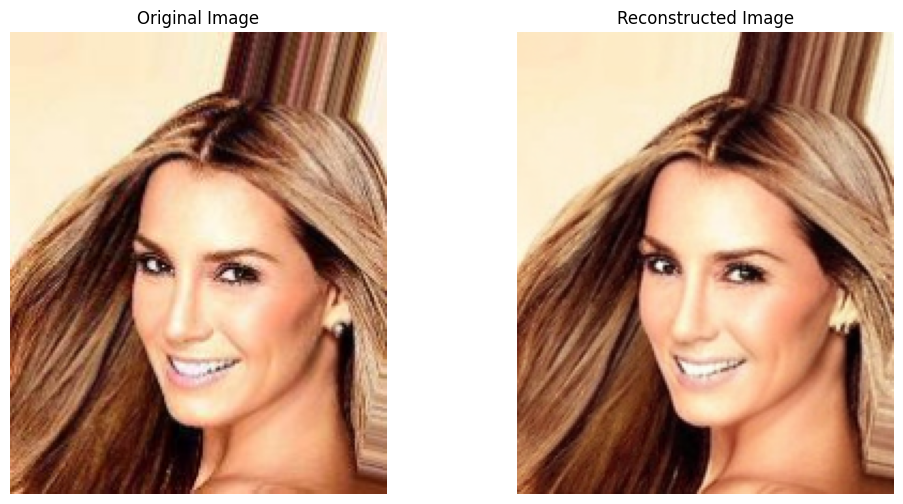

In [14]:
with torch.no_grad():
    # Move the tensors back to the CPU if they are on a GPU and remove the batch dimension
    img_cpu = train_ds[0]["image"].squeeze(0).cpu()
    reconstruction_cpu = reconstruction.squeeze(0).cpu()

    # Convert the tensors to numpy arrays for plotting
    img_np = img_cpu.permute(1, 2, 0).numpy()
    reconstruction_np = reconstruction_cpu.permute(1, 2, 0).numpy()

    # Rescale the reconstructed image from [-1, 1] to [0, 1]
    img_np = (img_np + 1) / 2
    reconstruction_np = (reconstruction_np + 1) / 2

    # Create a figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Display the original image
    axes[0].imshow(img_np)
    axes[0].set_title('Original Image')
    axes[0].axis('off')  # Hide the axes

    # Display the reconstructed image
    axes[1].imshow(reconstruction_np)
    axes[1].set_title('Reconstructed Image')
    axes[1].axis('off')  # Hide the axes

    # Show the plot
    plt.show()

In [15]:
def strings_to_tensor(string_list):
    """
    Converts a list of strings, each representing a list (e.g., "[1, 2, 3]"), 
    into a PyTorch tensor.

    Args:
        string_list (list of str): A list of strings, where each string is a list in string form.

    Returns:
        torch.Tensor: A PyTorch tensor containing the data from the lists.
    """
    # Convert each string to a list using eval
    list_of_lists = [eval(s) for s in string_list]
    
    # Convert the list of lists to a PyTorch tensor
    tensor = torch.tensor(list_of_lists, dtype=torch.float32)
    
    return tensor

In [44]:
input_dim = 4  # 4 channels in latent space
patch_size = 1 
embed_dim = 384
num_layers = 12
num_heads = 6
mlp_dim = embed_dim * 4
class_label_dim = 40  # 40 attributes in CelebA dataset
patch_mixer_layers = 2

epochs = 1000
mask_ratio = 0.25

In [45]:
model = MicroDiffusion(input_dim, patch_size, embed_dim, num_layers, num_heads, mlp_dim, class_label_dim, patch_mixer_layers=patch_mixer_layers)
model = model.to(device)

In [46]:
# Print model parameters count
print(sum(p.numel() for p in model.parameters()))

153450244


In [47]:
# Attempt overfitting to just one batch of images first
from torch.utils.data import Subset
subset = Subset(train_ds, range(9))
train_dl = DataLoader(subset, batch_size=9, shuffle=False, pin_memory=True, pin_memory_device=device)

In [48]:

# Define your loss function and optimizer as before
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# Calculate the total number of steps in your single epoch
# total_steps = len(train_dl) * epochs

# Add the OneCycleLR scheduler
# scheduler = OneCycleLR(optimizer, max_lr=1e-4, total_steps=total_steps)

In [49]:
scaler = GradScaler()

loss_history = []

pbar = tqdm(total=len(train_dl) * epochs)
for epoch in range(epochs):
    epoch_loss = 0.0

    for batch_idx, batch in enumerate(train_dl):
        bs = batch["latents"].shape[0]
        image_prompts = strings_to_tensor(batch["prompt_string"]).to(device)
        latents = batch["latents"].to(device)

        noise = torch.randn_like(latents, device=device)
        noise_amt = torch.rand(bs, device=device)

        noised_latents = latents * (1 - noise_amt.view(bs, 1, 1, 1)) + noise * noise_amt.view(bs, 1, 1, 1)

        mask = random_mask(bs, latents.shape[-2], latents.shape[-1], patch_size, mask_ratio=mask_ratio)
        masked_latents = latents * mask.unsqueeze(1).view(bs, 1, latents.shape[-2], latents.shape[-1])
        
        optimizer.zero_grad()

        with autocast():
            pred = model(noised_latents, noise_amt * 1000, image_prompts, mask)
            masked_preds = pred * mask.unsqueeze(1).view(bs, 1, latents.shape[-2], latents.shape[-1])
            loss = loss_fn(masked_preds, masked_latents) * 1/mask_ratio

        scaler.scale(loss).backward()
        
        # Gradient clipping
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        scaler.step(optimizer)
        scaler.update()
        # scheduler.step()

        loss_value = loss.item()
        epoch_loss += loss_value
        loss_history.append(loss_value)

        pbar.set_postfix({'loss': f'{loss_value:.4f}'})
        pbar.update(1)
    # Calculate average loss for the epoch
    avg_loss = epoch_loss / len(train_dl)
    if epoch % 50 == 0:
        print(f"Epoch {epoch+1} average loss: {avg_loss:.4f}")
    
    # Step the scheduler with the average loss
    # scheduler.step(avg_loss)

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch 1 average loss: 43.5015
Epoch 51 average loss: 43.4322
Epoch 101 average loss: 42.0803
Epoch 151 average loss: 41.2781
Epoch 201 average loss: 41.2305
Epoch 251 average loss: 40.8972
Epoch 301 average loss: 41.8694
Epoch 351 average loss: 38.9800
Epoch 401 average loss: 38.3721
Epoch 451 average loss: 37.3710
Epoch 501 average loss: 35.5848
Epoch 551 average loss: 35.5033
Epoch 601 average loss: 36.3909
Epoch 651 average loss: 34.0964
Epoch 701 average loss: 35.2488
Epoch 751 average loss: 35.5118
Epoch 801 average loss: 33.6806
Epoch 851 average loss: 34.3542
Epoch 901 average loss: 33.7934
Epoch 951 average loss: 34.1345


In [50]:
# import os

# # Create models directory if it doesn't exist
# os.makedirs('models/diffusion', exist_ok=True)

# # Save the model
# torch.save(model.state_dict(), 'models/diffusion/microdiffusion_model.pth')

# print("Model saved successfully.")


In [51]:
# # Load the saved model
# model_path = 'models/diffusion/microdiffusion_model.pth'
# model.load_state_dict(torch.load(model_path))
# model.eval()  # Set the model to evaluation mode

# print("Model loaded successfully.")


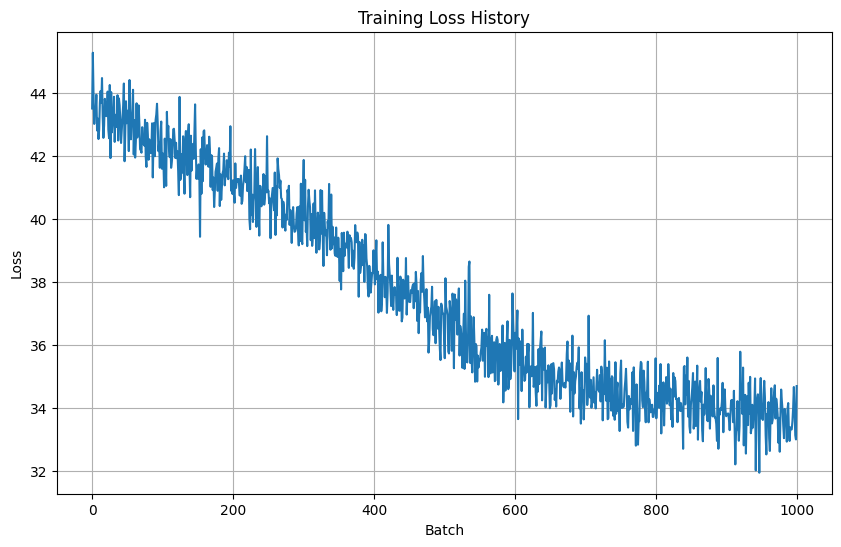

In [52]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_history)
plt.title('Training Loss History')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


In [53]:
def sample(model, class_labels, mask, bs: int = 9, steps: int = 100):
    x = torch.randn(bs, 4, 27, 22).to(device)

    pred_weight = 4/steps
    x_weight = 1 - pred_weight

    for step in range(steps):
        timestep = ((steps - step) * 1000 / steps) * torch.ones(bs, device=device)
        pred = model.forward(x, timestep, class_labels, mask)
        x = x * x_weight + pred * pred_weight
    return x

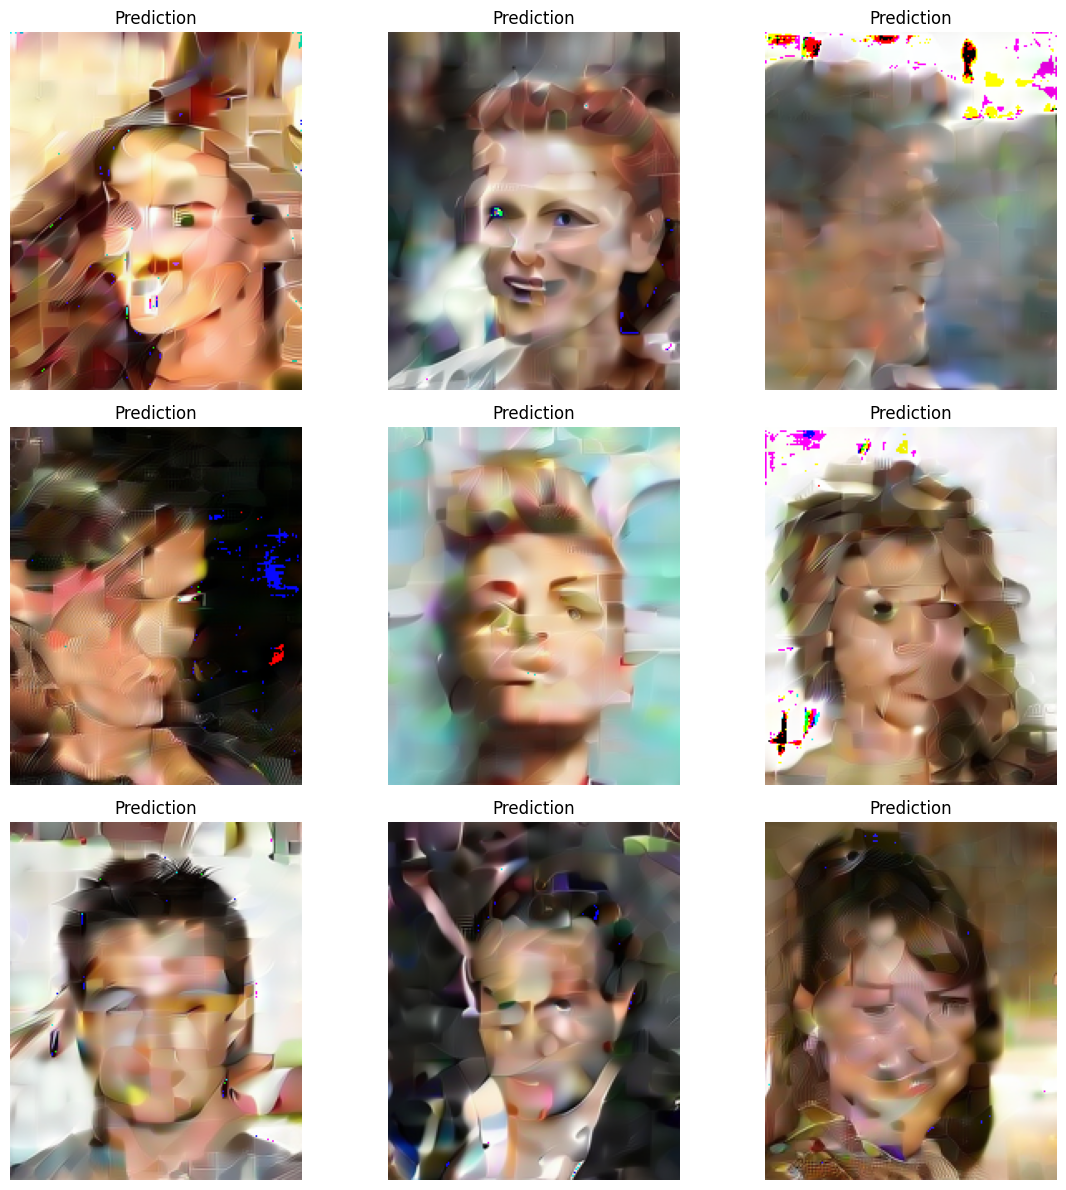

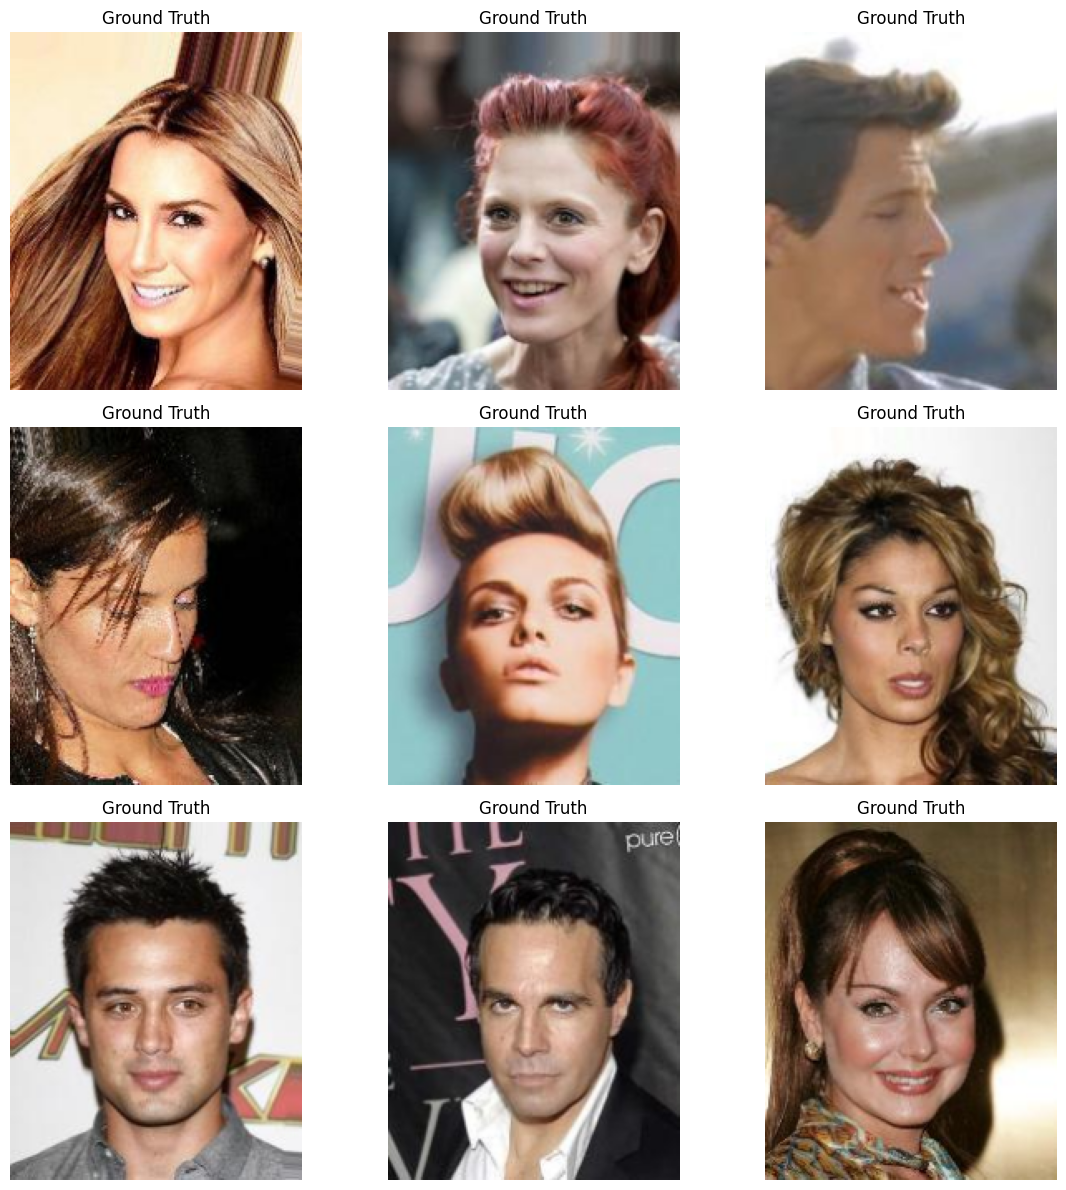

In [54]:
mask = random_mask(9, latents.shape[-2], latents.shape[-1], patch_size, 1.)
noise = torch.randn(9, 4, 27, 22).to(device)
noise_level = torch.ones(9).to(device)

image_prompts = train_ds[0:9]["prompt_string"]
image_prompts = strings_to_tensor(image_prompts).to(device)

with torch.no_grad():
    with autocast():
        # pred = model.forward(noise, noise_level*1000, image_prompts, mask)
        pred = sample(model, image_prompts, mask, steps=10)
        pred = vae.decode(pred).sample

ground_truth = train_ds[0:9]["image"]

with torch.no_grad():
    pred_cpu = pred.cpu()
    pred_np = pred_cpu.permute(0, 2, 3, 1).numpy()
    pred_np = (pred_np + 1) / 2
    pred_np = (pred_np * 255).astype(np.uint8)  # Convert to uint8

    ground_truth_cpu = ground_truth.cpu()
    ground_truth_np = ground_truth_cpu.permute(0, 2, 3, 1).numpy()
    ground_truth_np = (ground_truth_np + 1) / 2
    ground_truth_np = (ground_truth_np * 255).astype(np.uint8)  # Convert to uint8
    # Create figure for predictions
    fig_pred, axes_pred = plt.subplots(3, 3, figsize=(12, 12))  # 3 rows, 3 columns

    # Plot predictions
    for i, ax in enumerate(axes_pred.flatten()):
        if i < pred_np.shape[0]:
            ax.imshow(pred_np[i])
            ax.set_title('Prediction')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

    # Create figure for ground truth
    fig_gt, axes_gt = plt.subplots(3, 3, figsize=(12, 12))  # 3 rows, 3 columns

    # Plot ground truth
    for i, ax in enumerate(axes_gt.flatten()):
        if i < ground_truth_np.shape[0]:
            ax.imshow(ground_truth_np[i])
            ax.set_title('Ground Truth')
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()